In [10]:
import os
import astropy
from astropy.table import Table
from astropy import units as u
from astropy import constants as consts
from progress_bar import progress_bar
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import argrelmax, argrelmin
from scipy.optimize import curve_fit
from copy import deepcopy
plt.rcParams['figure.dpi'] = 150
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\n'.join(
                                        [r'\usepackage{siunitx}',
                                         r'\usepackage{mhchem}'])

$$\frac{\lambda - \lambda_0}{\lambda_0} = z$$
$$\lambda = \lambda_0(z+1)$$

In [2]:
si2 = 6356*u.Angstrom

In [3]:
spectra = Table.read('wiserep_spectra.csv', format='csv', encoding='utf8')

In [4]:
len(spectra)

28314

In [5]:
ia_mask = spectra['Obj. Type'] == 'SN Ia'
ia91bg_mask = spectra['Obj. Type'] == 'SN Ia-91bg-like'
ia91T_mask = spectra['Obj. Type'] == 'SN Ia-91T-like'

snia = spectra[ia_mask]
snia91bg = spectra[ia91bg_mask]
snia191T = spectra[ia91T_mask]

In [6]:
def signal_to_noise(data: np.ndarray):
    mean = data.sum(0)/len(data)
    chi2 = ((data-mean)**2).sum()
    stddev = (chi2/(len(data)-1))**0.5
    s2n = mean/stddev
    return s2n
def calculate_intervals(x: np.ndarray):
    return  x[1:] - x[0:len(x)-1]

print(calculate_intervals(np.array([0, 1, 1, 2, 3, 5, 8, 13])))

[1 0 1 1 2 3 5]


In [7]:
def gaussian(x, x0 = 0, sigma = 1):
    scalar = 1/(np.sqrt(2*np.pi)*sigma)
    return scalar * np.exp((-(x-x0)**2)/(2*sigma**2))

def gaussian_filter(x, x0, y, sigma):
    gauss = gaussian(x, x0, sigma)
    gauss /= gauss.sum()
    return (y * gauss).sum()

def smooth_data(x, y, sigma):
    y_smooth = np.zeros_like(y)
    for i,x0 in enumerate(x):
        y_smooth[i] = gaussian_filter(x, x0, y, sigma)
    return y_smooth

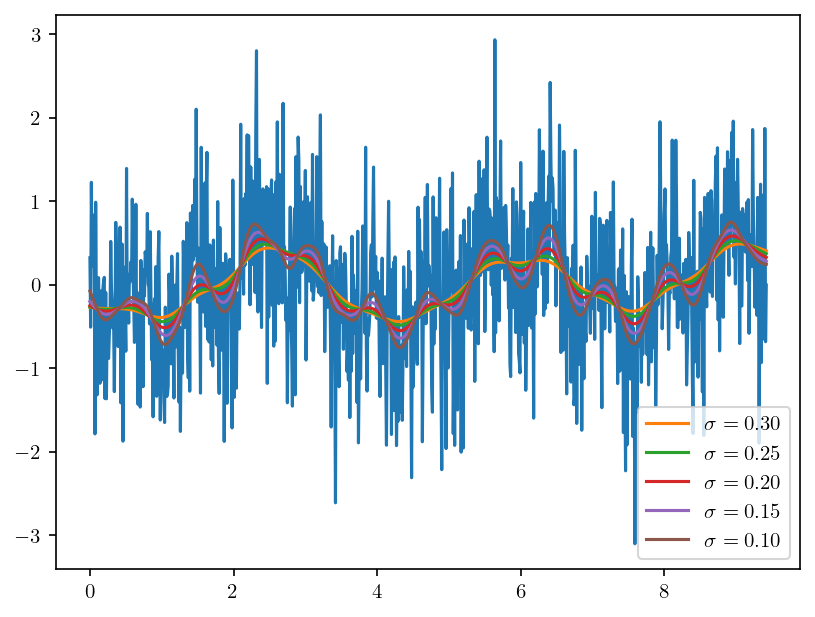

In [8]:
tx = np.arange(0, 3*np.pi, .01)
ty = np.sum([np.random.uniform(0, 10) * np.sin(np.random.uniform(-3*np.pi, 3*np.pi)*tx + np.random.uniform(0, 2*np.pi))+np.random.normal(0, 0.5, len(tx)) for i in range(np.random.randint(1, 10))], axis=0)
plt.plot(tx, ty)
for i in range(6, 1, -1):
    plt.plot(tx, smooth_data(tx, ty, 0.05*i), label=rf'$\sigma={i*.05: .2f}$')
plt.legend()

$$\frac{\lambda - \lambda_0}{\lambda_0} = z$$
$$\lambda = \lambda_0(z+1)$$

In [9]:
def kde(data: np.ndarray, bins: int | np.ndarray = 100, sigma: float = 1.0) -> list[np.ndarray, np.ndarray]:
    '''
    Returns
    -------
    `list[x, y]`
    '''
    def kde_gaussian(grid: np.ndarray, center: float, sigma: float = 1.0):
        return np.exp(-((grid - center)**2) / (2*sigma))
    if isinstance(bins, np.ndarray):
        r = bins
    else:
        r = np.linspace(np.min(data) - 3*sigma, np.max(data) + 3*sigma, bins)
    
    values = np.zeros_like(r)

    for d in data:
        values += kde_gaussian(r, d, sigma)
    
    return (r, values)

In [ ]:
print(spectra.columns)

In [ ]:
success_count = 0

analyzed_spectra: Table = deepcopy(spectra)
new_col_names = ['Has SiII','Ejecta Redshift', 'Mean Resolution', 'Signal to Noise', 'Successful Read']
analyzed_spectra.add_columns([[None]*len(spectra) for col in new_col_names], names=new_col_names)

def data_validator(spec: Table, max_mean_interval: float, min_s2n: float):
    intervals = calculate_intervals(spec['Wavelength'].data)
    if intervals.mean() > max_mean_interval:
        return False
    s2n = signal_to_noise(spec['Flux'])
    if s2n < min_s2n:
        return False
    return True

for n in range(len(spectra)):
    file = f'wiserep_data/{spectra['Ascii file'][n]}'
    try:
        spec: Table = Table.read(f'{file}', format='ascii')
        spec.rename_columns([spec.colnames[i] for i in (0,1)], ['Wavelength', 'Flux'])
        
        success_count += 1
        analyzed_spectra['Successful Read'][n] = True
        
        spec['Wavelength'].unit = u.Angstrom
        analyzed_spectra['Mean Resolution'][n] = calculate_intervals(spec['Wavelength'].data).mean()
        analyzed_spectra['Signal to Noise'][n] = signal_to_noise(spec['Flux'])

        z = spectra['Redshift'][n]
        spec['Wavelength'] *= (z+1) #translate the Wavelengths to what they would be if the progenitor had 0 radial velocity
        if np.max(spec['Wavelength']) >= 6536:
            analyzed_spectra['Has SiII'][n] = True
            wavelength_window = (spec['Wavelength'] > 5000) & (spec['Wavelength'] < 6536)
            spec = spec[wavelength_window]
            spec['Flux'] /= spec['Flux'][-1] #scale flux around the flux of the Si II line
            spec['Flux'] = smooth_data(spec['Wavelength'], spec['Flux'], 10)

            minima = argrelmin(spec['Flux'], order=20)
            absorption_line = spec['Wavelength'][minima[0][-1]] * u.Angstrom                
            analyzed_spectra['Ejecta Redshift'][n] = (((si2 - absorption_line) / absorption_line).to_value())
        else:
            analyzed_spectra['Has SiII'][n] = False

    except Exception as e:
        analyzed_spectra['Successful Read'][n] = False
        if isinstance(e, (astropy.io.ascii.InconsistentTableError, TypeError, UnicodeEncodeError)):
            pass #print(f'Error in {spectra['Ascii file'][n]}')
        else:
            pass
    progress_bar((n+1)/len(spectra), 100, f' {success_count}/{len(spectra)} - {success_count / len(spectra) : .2f}%')

analyzed_spectra.write('analyzed_spectra.csv', format='csv', encoding='utf8')

C:\Users\tobyh\AppData\Local\Temp\ipykernel_19240\2536871150.py:35: RuntimeWarning: divide by zero encountered in divide
  spec['Flux'] /= spec['Flux'][-1] #scale flux around the flux of the Si II line
C:\Users\tobyh\AppData\Local\Temp\ipykernel_19240\2536871150.py:35: RuntimeWarning: invalid value encountered in divide
  spec['Flux'] /= spec['Flux'][-1] #scale flux around the flux of the Si II line
C:\Users\tobyh\AppData\Local\Temp\ipykernel_19240\4125185970.py:8: RuntimeWarning: invalid value encountered in multiply
  return (y * gauss).sum()


 100.00% |████████████████████████████████████████████████████████████████████████████████████████████████████| 27217/28314 -  0.96%


UnicodeEncodeError: 'charmap' codec can't encode character '\u0142' in position 7337: character maps to <undefined>

In [49]:
# Need to write my own function because I get a unicode encode error
def write_table_csv(table: Table, output_file: str, encoding='utf8'):
    lines = []
    lines.append(f'{','.join(table.keys())}\n')
    for row in table:
        lines.append(f'{','.join([str(val).replace(',', '-') for val in row.values()])}\n') #remove commas items that are messing things up
    with open(output_file, 'w', encoding=encoding) as f:
        f.writelines(lines)

In [ ]:
analyzed_spectra_needed_rows = ['Obj. Id', 'Obj. Type', 'Redshift', 'Spec. ID', 'Obs-date', 'Has SiII','Ejecta Redshift', 'Mean Resolution', 'Signal to Noise', 'Successful Read']

In [50]:
write_table_csv(analyzed_spectra, 'analyzed_spectra.csv')

In [51]:
read_analyzed_spectra = Table.read('analyzed_spectra.csv', format='csv', encoding='utf8')

In [53]:
len(read_analyzed_spectra)

28356

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8,6))

kde_z, kde_y = kde(np.array(si2_absorption_z), np.arange(-0.1, 0.1, 0.0001), 0.001)

ax[0].set_xlim((5000, 6356))
ax[0].set_ylim(bottom = 0)
ax[0].set_xlabel(r"Wavelength ($\unit{\angstrom}$) Normalized to Rest")
ax[0].set_ylabel(r"Flux Normalized around $\ce{Si}\text{ II} = 6356 \unit{\angstrom}$")
ax[1].fill_between(kde_z, kde_y, np.zeros_like(kde_z))
plt.tight_layout()
plt.savefig('smoothed_spectra.png')

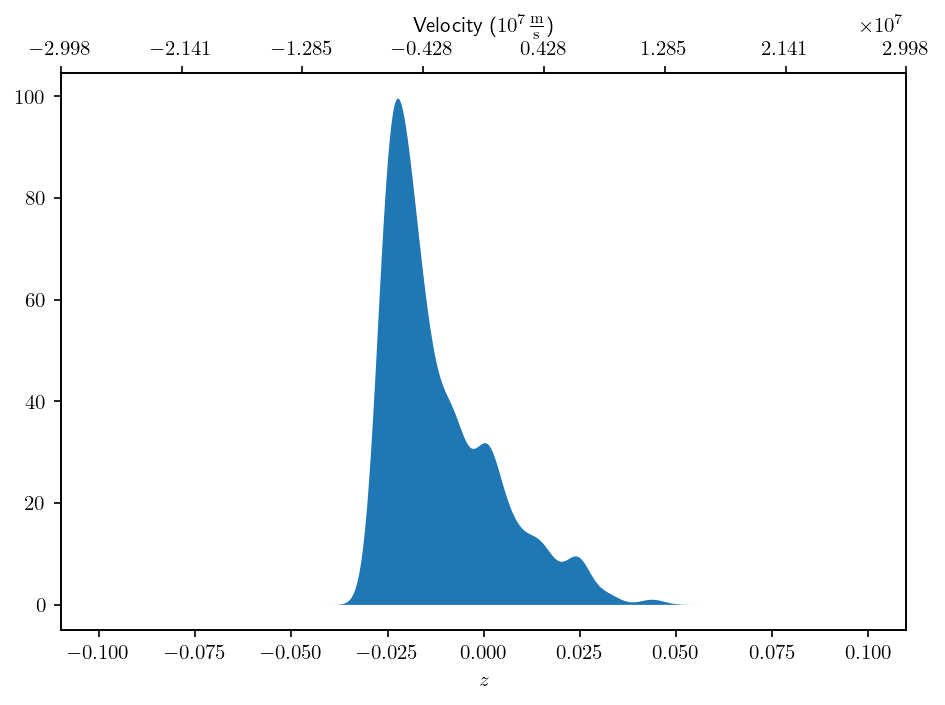

In [ ]:
read_absorption = []
with open('si2_absorption_z.txt', 'r') as f:
    lines = f.readlines()
    [read_absorption.append(float(l)) for l in lines]

fig, ax = plt.subplots()


kde_z, kde_y = kde(np.array(read_absorption), np.arange(-0.1, 0.1, 0.0001), 0.00001)

ax.fill_between(kde_z, kde_y, np.zeros_like(kde_z))
ax.set_xlabel('$z$')
ax_top = ax.twiny()
ax_top.set_xticks(np.linspace(-0.1*consts.c.to_value(), 0.1*consts.c.to_value(), 8))
ax_top.set_xlabel(r'Velocity ($10^7\frac{\unit{m}}{\unit{s}}$)')
plt.tight_layout()
plt.show()